In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import sbi
from scipy.stats import gaussian_kde
import torch

from CASBI.generator.fff.fff_model import FreeFormFlow


from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_custom_prior,
    process_simulator,
)

In [4]:
Flow = FreeFormFlow(dim = 2, 
                    cond_dim = 6,
                    hidden_dim = 256,
                    latent_dim = 2,
                    n_SC_layer = 12,
                    beta = 100**2,
                    device = 'cpu')

Flow.load_state_dict(torch.load('./snapshot/fff_snapshot/snapshot_256_12.pth'))

<All keys matched successfully>

## KDE_conditional_prior

In [33]:
class gen_halo_conditions(torch.distributions.Distribution):
    def __init__(self, conditions:pd.DataFrame, n_bins:int=100, n_halos:int=10, ):
        super().__init__()

        self.conditions = conditions
        self.masses = conditions['star_log10mass']
        self.bin_mass = (max(self.masses) - min(self.masses))/n_bins
        self.n_halos = n_halos
    
    def gen_conditions(self):
        """Generate sample conditions based on given conditions, taking into account correlations between conditions.

        Args:
            conditions (pandas.DataFrame): The conditions to generate sample conditions from.
            n_bins (int, optional): The number of bins to use for generating sample conditions. Defaults to 100.

        Returns:
            dict: The generated sample conditions.

        """
        sample_conditions = []
        for j in range(self.n_halos):
            kde = gaussian_kde(self.masses)
            star_mass = kde.resample(1)[0][0]
            sample_conditions.append(star_mass)
            
            cut_in_mass = self.conditions[(star_mass - self.bin_mass < self.masses) & (self.masses<star_mass + self.bin_mass)]
            conditions_to_sample = cut_in_mass.columns.difference(['star_log10mass', 'infall_time', 'Galaxy_name'], sort=False)
        
            for i, col in enumerate(conditions_to_sample):
                possible_cond = cut_in_mass[col].values
                kde = gaussian_kde(possible_cond)
                sample_conditions.append(kde.resample(1)[0][0])

            kde = gaussian_kde(self.conditions['infall_time'])
            infall_time = kde.resample(1)[0][0]
            sample_conditions.append(infall_time)
        
        return torch.tensor(sample_conditions, dtype=torch.float32)
    
    def sample(self, sample_shape=torch.Size([2]), ):
        """
        Generate conditions in a hierarchical way, with Gas Mass, dm mass, std and mean metallicity depend hierarchically from Star mass, 
        Infall time is independed from all the others.
        """
        genereated_halo_conditions = torch.zeros((sample_shape[0], self.n_halos*6))
        for n in range(sample_shape[0]):
            sample_conditions = self.gen_conditions()
            genereated_halo_conditions[n] = sample_conditions
        return torch.tensor(genereated_halo_conditions, dtype=torch.float32)

    def log_prob(self, value):
        """
        Hierarchical prior for the halo conditions.
        """
        log_prob = np.zeros(value.shape[0])
        for j in range(len(value)):
            temp_log_prob = 0
            for n in range(self.n_halos):
                star_mass = value[j, 6*n]
                kde = gaussian_kde(self.masses)
                temp_log_prob += kde.logpdf(star_mass)
                cut_in_mass = self.conditions[(star_mass.numpy() - self.bin_mass < self.masses) & (self.masses <star_mass.numpy() + self.bin_mass)]
                for i in range(1, 5):
                    possible_cond = cut_in_mass[cut_in_mass.columns[i]].values
                    kde = gaussian_kde(possible_cond)
                    temp_log_prob += kde.logpdf(value[j, 6*n + i])
                kde = gaussian_kde(self.conditions['infall_time'])
                temp_log_prob += kde.logpdf(value[j, 6*n+5])
                log_prob[j] = temp_log_prob
        
        return torch.tensor(log_prob)
    

In [5]:
data = pd.read_parquet('../../data/dataframe/dataframe.parquet')
data =  data.drop(['a','redshift', 'mean_FeMassFrac', 'std_FeMassFrac', 'mean_OMassFrac', 'std_OMassFrac'], axis=1)
conditions = data[data.columns.difference(['feh', 'ofe'], sort=False)]
halo_cond = gen_halo_conditions(conditions=conditions)
sample_halo = halo_cond.sample(sample_shape=torch.tensor((10,)))
log_prob = generated_halo.log_prob(sample_halo)
# generated_halo = gen_halo(generated_conditions, Flow)
print(sample_halo.shape, log_prob.shape)

NameError: name 'gen_halo_conditions' is not defined

## Gaussian_conditional_prior (implement only sampling for gas_mass)

In [12]:
class gen_halo_conditions(torch.distributions.Distribution):
    def __init__(self, conditions:pd.DataFrame, n_bins:int=10, n_halos:int=10, return_numpy:bool=False):
        super().__init__()
        self.n_bins = n_bins
        self.mass_range = (min(conditions['star_log10mass']), max(conditions['star_log10mass']))
        self.bins = torch.linspace(self.mass_range[0], self.mass_range[1], self.n_bins)
        self.bin_indices =  torch.from_numpy(np.digitize(conditions['star_log10mass'], self.bins))
        self.conditions = conditions
        self.n_halos = n_halos
        self.return_numpy = return_numpy
        
    def torch_digitize(self, x, bins):
        bins = self.bins[:-1]
        idx = torch.searchsorted(bins, x)
        return idx    
    
    def sample(self, sample_shape):
        star_mass = torch.distributions.Uniform(low=self.mass_range[0], high=self.mass_range[1]).sample(torch.tensor([sample_shape[0], self.n_halos]))
        idx = self.torch_digitize(star_mass, self.bins)
        gas_mass =  torch.zeros_like(star_mass)
        for n_i, i in enumerate(range(idx.shape[0])):
            for n_j, j in enumerate(range(idx.shape[1])):
                mean_gas = torch.from_numpy(self.conditions['gas_log10mass'].values)[self.bin_indices == idx[i, j]].mean() 
                std_gas = torch.from_numpy(self.conditions['gas_log10mass'].values)[self.bin_indices == idx[i, j]].std()
                gas_mass[i, j] = torch.distributions.Normal(loc=mean_gas, scale=std_gas).sample()
        if self.return_numpy:
            return torch.hstack((star_mass, gas_mass)).numpy()
        else:
            return torch.hstack((star_mass, gas_mass))
    
    def log_prob(self, value):
        star_mass = value[:, :self.n_halos]
        gas_mass = value[:, self.n_halos:]
        log_prob = torch.zeros(value.shape[0])
        for i in range(value.shape[0]):
            for j in range(self.n_halos):
                log_prob[i] += torch.distributions.Uniform(low=self.mass_range[0], high=self.mass_range[1]).log_prob(star_mass[i, j])
                idx = self.torch_digitize(star_mass[i, j], self.bins)
                mean_gas = torch.from_numpy(self.conditions['gas_log10mass'].values)[self.bin_indices == idx].mean()
                std_gas = torch.from_numpy(self.conditions['gas_log10mass'].values)[self.bin_indices == idx].std()
                log_prob[i] += torch.distributions.Normal(loc=mean_gas, scale=std_gas).log_prob(gas_mass[i, j])
        if self.return_numpy:
            return log_prob.numpy()
        else:
            return log_prob        
    

In [13]:
prior =  gen_halo_conditions(conditions=conditions)
parameters =  prior.sample((2, ))
log_prob = prior.log_prob(parameters)
print(log_prob.shape)

/export/home/vgiusepp/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:53: UserWarning: <class '__main__.gen_halo_conditions'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


# SBI with independent assumption of the parameters

In [56]:
Flow = FreeFormFlow(dim = 2, 
                    cond_dim = 6,
                    hidden_dim = 128,
                    latent_dim = 2,
                    n_SC_layer = 6,
                    beta = 100**2,
                    device = 'cuda:1')

Flow.load_state_dict(torch.load('./snapshot/fff_snapshot/best_snapshot.pth'))

<All keys matched successfully>

torch.Size([10, 12])


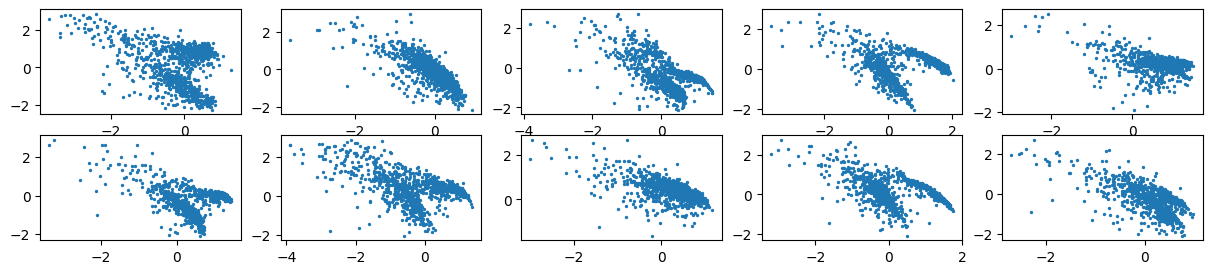

In [5]:
def simulator(theta, model, n_halos):
    with torch.no_grad():
        model.eval()
        batch_halos =  torch.zeros(theta.shape[0], 500*n_halos, 2)
        for n, batch in enumerate(theta):
            for i in range(n_halos):
                if i==0:
                    cond = batch[i::n_halos].repeat(500, 1)
                    halo = model.sample(500, cond=cond)
                else:
                    cond = batch[i::n_halos].repeat(500, 1)
                    halo = torch.vstack((halo, model.sample(500, cond=cond)))
            batch_halos[n] = halo
        return batch_halos

n_halos=2
batch = 10
for b in range(batch):
    data =  pd.read_parquet('../../data/dataframe/dataframe.parquet')
    data = data.drop(['feh', 'ofe', 'a','redshift', 'mean_FeMassFrac', 'std_FeMassFrac', 'mean_OMassFrac', 'std_OMassFrac'], axis=1)
    data = data[data['Galaxy_name'].isin(data['Galaxy_name'].sample(n_halos))].drop_duplicates()
    data =  data.drop(['Galaxy_name'],axis=1).values
    data = data.T.reshape(-1)
    if b == 0:
        theta =  data
    else:
        theta = np.vstack((theta, data))
        
theta = torch.from_numpy(theta).float().to(Flow.device)        
print(theta.shape)
# theta = torch.utils.data.DataLoader(torch.from_numpy(theta).float().to(Flow.device), batch_size=batch)
halos = simulator(theta, Flow, n_halos)
halos =  halos.cpu()
fig = plt.figure(figsize=(15, 3))
for i in range(batch):
    ax = fig.add_subplot(2, int(batch/2), i+1)
    ax.scatter(halos[i, :, 0], halos[i, :, 1], s=2)


In [252]:
class gen_halo_conditions(torch.distributions.Distribution):
    #THIS IS VERY SLOW
    def __init__(self, conditions:pd.DataFrame, n_bins:int=10, n_halos:int=10, return_numpy:bool=False):
        super().__init__()
        self.n_bins = n_bins
        self.mass_range = (min(conditions['star_log10mass']), max(conditions['star_log10mass']))
        self.bins = torch.linspace(self.mass_range[0], self.mass_range[1], self.n_bins)
        self.bin_indices =  torch.from_numpy(np.digitize(conditions['star_log10mass'], self.bins))
        self.conditions = conditions
        self.n_halos = n_halos
        self.return_numpy = return_numpy
        
    def torch_digitize(self, x, bins):
        bins = self.bins[:-1]
        idx = torch.searchsorted(bins, x)
        return idx    
    
    def sample(self, sample_shape):
        infall_time = torch.distributions.Uniform(low=min(self.conditions['infall_time']), high=max(self.conditions['infall_time'])).sample(torch.tensor([sample_shape[0], self.n_halos]))
        star_mass, _ = torch.sort(torch.distributions.Uniform(low=self.mass_range[0], high=self.mass_range[1]).sample(torch.tensor([sample_shape[0], self.n_halos])), descending=True)
        idx = self.torch_digitize(star_mass, self.bins)
        gas_mass =  torch.zeros_like(star_mass)
        dm_mass = torch.zeros_like(star_mass)
        mean_metallicity = torch.zeros_like(star_mass)
        std_metallicity = torch.zeros_like(star_mass)
        for n_i, i in enumerate(range(idx.shape[0])):
            for n_j, j in enumerate(range(idx.shape[1])):
                mean_gas = torch.from_numpy(self.conditions['gas_log10mass'].values)[self.bin_indices == idx[i, j]].mean() 
                std_gas = torch.from_numpy(self.conditions['gas_log10mass'].values)[self.bin_indices == idx[i, j]].std()
                gas_mass[i, j] = torch.distributions.Normal(loc=mean_gas, scale=std_gas).sample()
                
                mean_dm = torch.from_numpy(self.conditions['dm_log10mass'].values)[self.bin_indices == idx[i, j]].mean()
                std_dm = torch.from_numpy(self.conditions['dm_log10mass'].values)[self.bin_indices == idx[i, j]].std()
                dm_mass[i, j] = torch.distributions.Normal(loc=mean_dm, scale=std_dm).sample()
                
                mean_mean_metallicity = torch.from_numpy(self.conditions['mean_metallicity'].values)[self.bin_indices == idx[i, j]].mean()
                std_mean_metallicity = torch.from_numpy(self.conditions['mean_metallicity'].values)[self.bin_indices == idx[i, j]].std()
                mean_metallicity[i, j] = torch.distributions.Normal(loc=mean_mean_metallicity, scale=std_mean_metallicity).sample()
                
                mean_std_metallicity = torch.from_numpy(self.conditions['std_metallicity'].values)[self.bin_indices == idx[i, j]].mean()
                std_std_metallicity = torch.from_numpy(self.conditions['std_metallicity'].values)[self.bin_indices == idx[i, j]].std()
                std_metallicity[i, j] = torch.distributions.Normal(loc=mean_std_metallicity, scale=std_std_metallicity).sample()
                
        if self.return_numpy:
            return torch.hstack((star_mass, gas_mass, dm_mass, mean_metallicity, std_metallicity, infall_time)).numpy()
        else:
            return torch.hstack((star_mass, gas_mass, dm_mass, mean_metallicity, std_metallicity, infall_time))
    ## Not yet implemented correctly missing selection of the single halo condition in the value tensor
    # def log_prob(self, value):
    #     star_mass = value[:, :self.n_halos]
    #     gas_mass = value[:, self.n_halos:]
    #     log_prob = torch.zeros(value.shape[0])
    #     for i in range(value.shape[0]):
    #         for j in range(self.n_halos):
    #             log_prob[i] += torch.distributions.Uniform(low=self.mass_range[0], high=self.mass_range[1]).log_prob(star_mass[i, j])
    #             idx = self.torch_digitize(star_mass[i, j], self.bins)
    #             mean_gas = torch.from_numpy(self.conditions['gas_log10mass'].values)[self.bin_indices == idx].mean()
    #             std_gas = torch.from_numpy(self.conditions['gas_log10mass'].values)[self.bin_indices == idx].std()
    #             log_prob[i] += torch.distributions.Normal(loc=mean_gas, scale=std_gas).log_prob(gas_mass[i, j])
    #             mean_dm = torch.from_numpy(self.conditions['dm_log10mass'].values)[self.bin_indices == idx].mean()
    #             std_dm = torch.from_numpy(self.conditions['dm_log10mass'].values)[self.bin_indices == idx].std()
    #             log_prob[i] += torch.distributions.Normal(loc=mean_dm, scale=std_dm).log_prob(dm_mass[i, j])
    #             mean_mean_metallicity = torch.from_numpy(self.conditions['mean_metallicity'].values)[self.bin_indices == idx].mean()
    #             std_mean_metallicity = torch.from_numpy(self.conditions['mean_metallicity'].values)[self.bin_indices == idx].std()
    #             log_prob[i] += torch.distributions.Normal(loc=mean_mean_metallicity, scale=std_mean_metallicity).log_prob(mean_metallicity[i, j])
    #             mean_std_metallicity = torch.from_numpy(self.conditions['std_metallicity'].values)[self.bin_indices == idx].mean()
    #             std_std_metallicity = torch.from_numpy(self.conditions['std_metallicity'].values)[self.bin_indices == idx].std()
    #             log_prob[i] += torch.distributions.Normal(loc=mean_std_metallicity, scale=std_std_metallicity).log_prob(std_metallicity[i, j])
                
    #     if self.return_numpy:
    #         return log_prob.numpy()
    #     else:
    #         return log_prob        
    

/export/home/vgiusepp/.local/lib/python3.10/site-packages/torch/distributions/distribution.py:53: UserWarning: <class '__main__.gen_halo_conditions'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


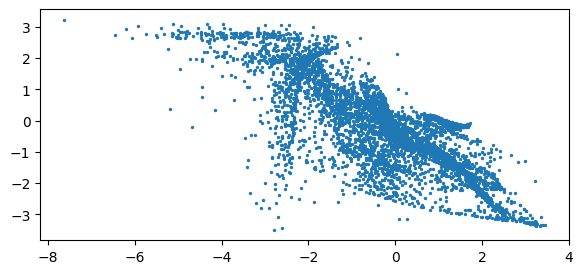

In [253]:
data = pd.read_parquet('../../data/dataframe/dataframe.parquet')
data =  data.drop(['a','redshift', 'mean_FeMassFrac', 'std_FeMassFrac', 'mean_OMassFrac', 'std_OMassFrac'], axis=1)
conditions = data[data.columns.difference(['feh', 'ofe'], sort=False)]
prior = gen_halo_conditions(conditions=conditions, n_bins=10, n_halos=10, return_numpy=False)

sample_prior = prior.sample((1, ))
halos = simulator(sample_prior, Flow, n_halos=int(sample_prior.shape[1]/6))
halos =  halos.cpu()
fig = plt.figure(figsize=(15, 3))
for i in range(halos.shape[0]):
    ax = fig.add_subplot(1, 2, i+1)
    ax.scatter(halos[i, :, 0], halos[i, :, 1], s=2)

In [6]:
class gen_halo_conditions_numpy():
    def __init__(self, conditions:pd.DataFrame, n_bins:int=10, n_halos:int=10):
        super().__init__()
        self.n_bins = n_bins
        self.mass_range = (min(conditions['star_log10mass']), max(conditions['star_log10mass']))
        self.bins = np.linspace(self.mass_range[0], self.mass_range[1], self.n_bins)
        self.bin_indices =  np.digitize(conditions['star_log10mass'], self.bins)
        self.conditions = conditions
        self.n_halos = n_halos
        
    def np_digitize(self, x, bins):
        bins = self.bins[:-1]
        idx = np.searchsorted(bins, x)
        return idx    
    
    def sample(self, sample_shape):
        infall_time = np.random.uniform(low=min(self.conditions['infall_time']), high=max(self.conditions['infall_time']), size=[sample_shape[0], self.n_halos])
        star_mass = np.sort(np.random.uniform(low=self.mass_range[0], high=self.mass_range[1], size=[sample_shape[0], self.n_halos]))[:, ::-1]
        idx = self.np_digitize(star_mass, self.bins)
        gas_mass =  np.zeros_like(star_mass)
        dm_mass = np.zeros_like(star_mass)
        mean_metallicity = np.zeros_like(star_mass)
        std_metallicity = np.zeros_like(star_mass)
        for n_i, i in enumerate(range(idx.shape[0])):
            for n_j, j in enumerate(range(idx.shape[1])):
                mean_gas = self.conditions['gas_log10mass'].values[self.bin_indices == idx[i, j]].mean() 
                std_gas = self.conditions['gas_log10mass'].values[self.bin_indices == idx[i, j]].std()
                gas_mass[i, j] = np.random.normal(loc=mean_gas, scale=std_gas, )
                
                mean_dm = self.conditions['dm_log10mass'].values[self.bin_indices == idx[i, j]].mean()
                std_dm = self.conditions['dm_log10mass'].values[self.bin_indices == idx[i, j]].std()
                dm_mass[i, j] = np.random.normal(loc=mean_dm, scale=std_dm, )
                
                mean_mean_metallicity = self.conditions['mean_metallicity'].values[self.bin_indices == idx[i, j]].mean()
                std_mean_metallicity = self.conditions['mean_metallicity'].values[self.bin_indices == idx[i, j]].std()
                mean_metallicity[i, j] = np.random.normal(loc=mean_mean_metallicity, scale=std_mean_metallicity,)
                
                mean_std_metallicity = self.conditions['std_metallicity'].values[self.bin_indices == idx[i, j]].mean()
                std_std_metallicity = self.conditions['std_metallicity'].values[self.bin_indices == idx[i, j]].std()
                std_metallicity[i, j] = np.random.normal(loc=mean_std_metallicity, scale=std_std_metallicity, )
        else:
            return np.hstack((star_mass, gas_mass, dm_mass, mean_metallicity, std_metallicity, infall_time))

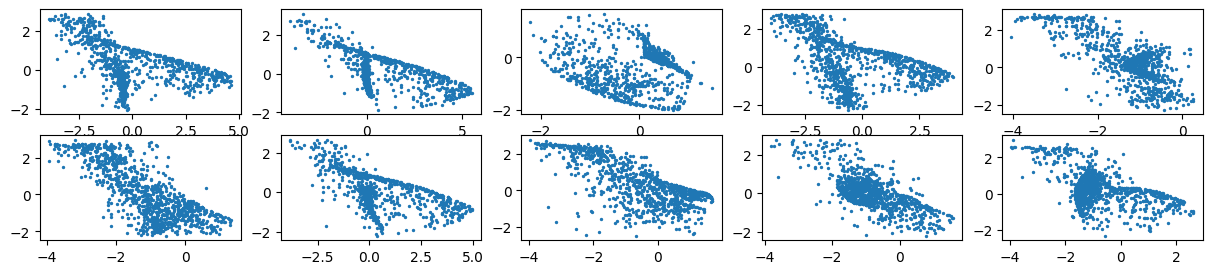

In [8]:
data = pd.read_parquet('../../data/dataframe/dataframe.parquet')
data =  data.drop(['a','redshift', 'mean_FeMassFrac', 'std_FeMassFrac', 'mean_OMassFrac', 'std_OMassFrac'], axis=1)
conditions = data[data.columns.difference(['feh', 'ofe'], sort=False)]
prior = gen_halo_conditions_numpy(conditions=conditions, n_bins=10, n_halos=2, )

sample_prior = prior.sample((10, ))
sample_prior = torch.from_numpy(sample_prior).float().to(Flow.device)
halos = simulator(sample_prior, Flow, n_halos=int(sample_prior.shape[1]/6))
halos = halos.cpu()
fig = plt.figure(figsize=(15, 3))
for i in range(halos.shape[0]):
    ax = fig.add_subplot(2, int(halos.shape[0]/2), i+1)
    ax.scatter(halos[i, :, 0], halos[i, :, 1], s=2)